In [1]:
from __future__ import print_function
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)
GPflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

In [15]:
Y = np.load("cnn_embedding.npz")['emb']
Y = Y[:1000,:]
print('Number of points X Number of dimensions', Y.shape)

Number of points X Number of dimensions (1000, 128)


In [23]:
Q = 10
M = 40  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = ekernels.Add([ekernels.RBF(3, ARD=True, active_dims=slice(0,3)),
                  ekernels.Linear(2, ARD=False, active_dims=slice(3,5))])
else:
    k = ekernels.Add([ekernels.RBF(3, ARD=True, active_dims=[0,1,2]),
                  ekernels.Linear(2, ARD=False, active_dims=[3, 4])])

m = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01
m.optimize(disp=True, maxiter=100)

/Users/tobias/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      fun: array([-141411.53916878])
 hess_inv: <20406x20406 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.90789488e+01,   3.67597339e+01,  -6.46872767e+01, ...,
         8.31669639e-04,   7.54118173e-04,  -1.08470777e+02])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 121
      nit: 101
   status: 1
  success: False
        x: array([ -7.13004849e+00,  -5.81069336e+00,   1.65907152e+00, ...,
         8.31669639e-04,   7.54118173e-04,  -5.24528166e+00])

kern.linear.variance transform:+ve prior:None
[ 0.00080136]
kern.rbf.variance transform:+ve prior:None
[ 0.00299188]
kern.rbf.lengthscales transform:+ve prior:None
[ 1.833291    2.07163558  2.86102729]
[ 0.02983598  0.02640331  0.01911832]


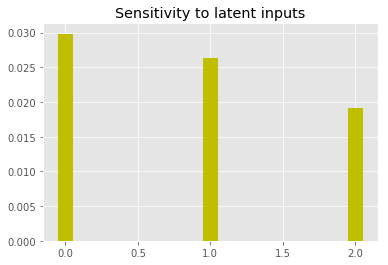

In [25]:
kern = m.kern.kern_list[0]
sens = np.sqrt(kern.variance.value)/kern.lengthscales.value
print(m.kern)
print(sens)
fig, ax = plt.subplots()
ax.bar(np.arange(len(kern.lengthscales.value)) , sens, 0.1, color='y')
ax.set_title('Sensitivity to latent inputs')

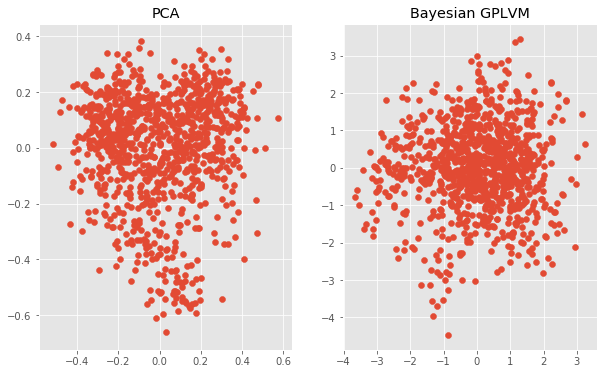

In [26]:
XPCAplot = GPflow.gplvm.PCA_reduce(Y, 2)
f, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].scatter(XPCAplot[:,0], XPCAplot[:,1])
ax[0].set_title('PCA')
ax[1].scatter(m.X_mean.value[:,1], m.X_mean.value[:,2])
ax[1].set_title('Bayesian GPLVM')